In [1]:
# Austin Griffith
# Python 3.6.5
# 4/25/2018

import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import networkx as nx

In [2]:
# set up plotting parameters
params = {'legend.fontsize': 20,
          'figure.figsize': (13,9),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)

In [3]:
# graph all nodes and paths
def networkCompletePlot(solution,maxNode):
    G = nx.DiGraph()
    G.add_nodes_from(range(0,maxNode+1))
    for i,j in nodes:
        G.add_edge(i,j)

    # get solution nodes
    sp = [i for i,j in solution[1]]
    sp.append(end)

    colorNode = ['white' if not node in sp else 'red' for node in G.nodes()]
    title = 'Complete Network: Gamma = '+str(int(solution[0]))+', Opt Obj = '+str(round(solution[2],5))
    nx.draw_networkx(G,node_color=colorNode,node_size=200)
    plt.axis('off')
    plt.title(title)
    plt.show()

# graph path, with costs on edges
def networkPathPlot(solution,maxNode,cost):
    # get solution nodes
    sp = [i for i,j in solution[1]]
    sp.append(end)

    # set up random position values
    a = np.arange(maxNode+1)
    b = np.arange(maxNode+1)
    np.random.shuffle(a)
    posArray = np.array([a,b]).transpose()

    positions = {}
    for p in range(0,len(sp)):
        L = posArray[p]
        positions[sp[p]] = (L[0],L[1])

    # set up network graph
    G = nx.DiGraph()
    G.add_nodes_from(sp)

    for i,j in tuplelist(solution[1]):
        G.add_edge(i,j)

    labels = {}
    for i in solution[1]:
        labels[i] = round(c[i],3)

    title = 'Optimal Path: Gamma = '+str(int(solution[0]))+', Opt Obj = '+str(round(solution[2],5))
    nx.draw_networkx(G,positions,node_size=350)
    nx.draw_networkx_edge_labels(G,positions,edge_labels=labels)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [4]:
# pull data
edges = pd.read_csv('edge_values.csv')
edges['i'] = np.int64(edges['i'])
edges['j'] = np.int64(edges['j'])

# create dictionaries of edge values
c = {}
d = {}
nodes = tuplelist()
for i in edges.index:
    c[edges['i'][i],edges['j'][i]] = edges['c(ij)'][i]
    d[edges['i'][i],edges['j'][i]] = edges['d(ij)'][i]
    nodes.append((edges['i'][i],edges['j'][i]))

maxNodes = max(edges['j'])
minNodes = min(edges['i'])

In [5]:
# choose start and end nodes
start = 0
end = int(maxNodes)

# allowed edge congestions
gend = 4
gammas = np.linspace(0,gend,gend+1)
print('Allowed Congestions:')
print(gammas)

Allowed Congestions:
[ 0.  1.  2.  3.  4.]


In [6]:
# initialize model
model = Model('Shortest_Path')

# set up x binary variables, set to each location/movement
xVars = model.addVars(nodes, vtype=GRB.BINARY, name='move')
y0 = model.addVar(vtype=GRB.CONTINUOUS, name='y0')
zVars = model.addVars(nodes, lb=0.0, vtype=GRB.CONTINUOUS, name='cong')
model.update()

In [7]:
# constrain all entrance and exit nodes
enterStart = []
leaveStart = []
enterEnd = []
leaveEnd = []
for n in nodes:
    # for start nodes
    if n[0] == start:
        leaveStart.append(xVars[n])
    elif n[1] == start:
        enterStart.append(xVars[n])
    # for end nodes
    if n[0] == end:
        leaveEnd.append(xVars[n])
    elif n[1] == end:
        enterEnd.append(xVars[n])

model.addConstr(quicksum(leaveStart) == 1)
model.addConstr(quicksum(enterStart) == 0)
model.addConstr(quicksum(leaveEnd) == 0)
model.addConstr(quicksum(enterEnd) == 1)
model.update()

In [8]:
# gather all paths
paths = []
for i in range(minNodes+1,maxNodes):
    pathFrom = []
    pathTo = []
    for n in nodes:
        if n[0] == i:
            pathFrom.append(xVars[n])
        elif n[1] == i:
            pathTo.append(xVars[n])
    paths.append([pathFrom,pathTo])
model.update()

for p in paths:
    model.addConstr(quicksum(p[0]) - quicksum(p[1]) == 0.0)
model.update()

print('Example of Path Constraint for a Given Node:')
print(quicksum(p[0]) - quicksum(p[1]))

Example of Path Constraint for a Given Node:
<gurobi.LinExpr: move[88,57] + move[88,55] + move[88,64] + move[88,30] + move[88,49] + move[88,65] + move[88,80] + move[88,46] + move[88,77] + move[88,85] + move[88,52] + move[88,41] + move[88,82] + move[88,69] + move[88,43] + move[88,58] + move[88,36] + move[88,86] + move[88,39] + move[88,50] + move[88,47] + move[88,89] + move[88,62] + move[88,71] + move[88,56] + move[88,51] + move[88,35] + move[88,40] + move[88,38] + move[88,68] + move[88,79] + move[88,54] + move[88,29] + move[88,70] + move[88,44] + move[88,76] + move[88,73] + move[88,81] + move[88,37] + move[88,88] + move[88,59] + move[88,66] + move[88,61] + move[88,31] + move[88,63] + move[88,33] + move[88,78] + move[88,42] + move[88,53] + move[88,75] + move[88,34] + move[88,74] + move[88,48] + move[88,83] + move[88,72] + move[88,45] + move[88,32] + move[88,87] + move[88,67] + move[88,84] + move[88,60] + -1.0 move[0,88] + -1.0 move[1,88] + -1.0 move[2,88] + -1.0 move[3,88] + -1.0 move[4,

In [9]:
# objective function
costObj = []
for n in nodes:
    costObj.append(xVars[n]*c[n])
    model.addConstr(zVars[n] >= xVars[n]*d[n] - y0)
model.update()

print('Example of Congestion Constraint:')
print(zVars[n],' >= ',xVars[n]*d[n] - y0)

Example of Congestion Constraint:
<gurobi.Var cong[90,42]>  >=  <gurobi.LinExpr: 3.88801471279467 move[90,42] + -1.0 y0>


In [10]:
# iterate optimization through various gammas (congestions)
output = []
for g in gammas:
    # optimize
    objective = quicksum(costObj) + g*y0 + quicksum(zVars)
    model.setObjective(objective, GRB.MINIMIZE)

    model.optimize()

    # order the printout of optimal edges
    moves = []
    for m in xVars:
        if xVars[m].x != 0:
            moves.append(m)
    order = [moves[0]]
    for i in range(len(moves)):
        for m in moves:
            if order[i][1] == m[0]:
                order.append(m)
    output.append([g,order,model.objVal])

Optimize a model with 6061 rows, 11939 columns and 29729 nonzeros
Variable types: 5970 continuous, 5969 integer (5969 binary)
Coefficient statistics:
  Matrix range     [9e-05, 5e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.9533653
Presolve removed 5971 rows and 6294 columns
Presolve time: 0.03s
Presolved: 90 rows, 5645 columns, 11180 nonzeros
Variable types: 0 continuous, 5645 integer (5645 binary)

Root relaxation: objective 9.273644e-02, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0927364    0.09274  0.00%     -    0s

Explored 0 nodes (24 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0927364 0.953365 

Optimal solution found (tolerance 1.00e-04)
Best object

     0     0    1.72042    0   28    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   28    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   24    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   20    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   19    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   18    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   16    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   15    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   16    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   16    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   16    1.80050    1.72042  4.45%     -    0s
     0     0    1.72042    0   14    1.80050    1.72042  4.45%     -    0s
     0     0    1.72883    0    8    1.80050    1.72883  3.98%     -    0s
     0     0    1.73773  


For Gamma: 0.0
Path:
[(0, 40), (40, 31), (31, 82), (82, 89)]
Cost of Movement (Objective):
0.0927364417874903


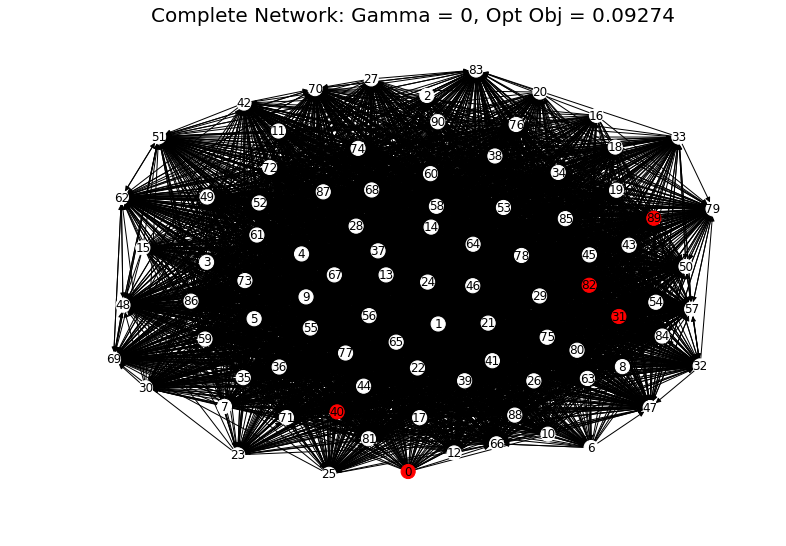

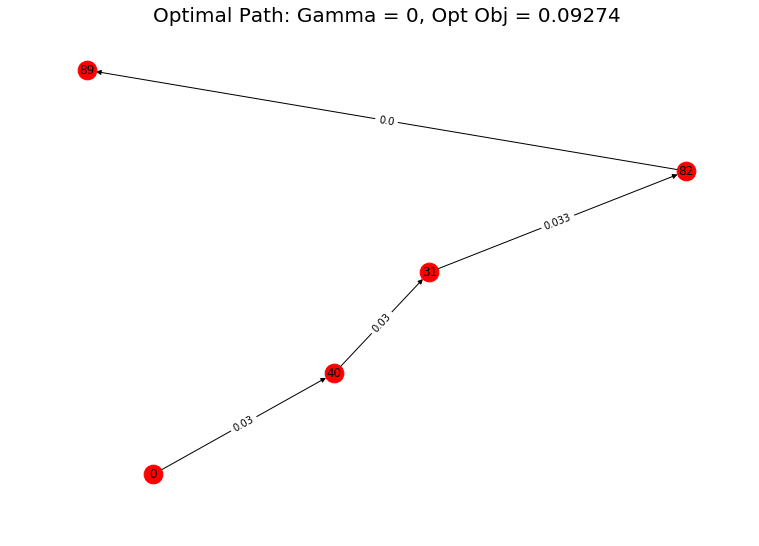


For Gamma: 1.0
Path:
[(0, 34), (34, 51), (51, 82), (82, 65), (65, 89)]
Cost of Movement (Objective):
1.2815288112962624


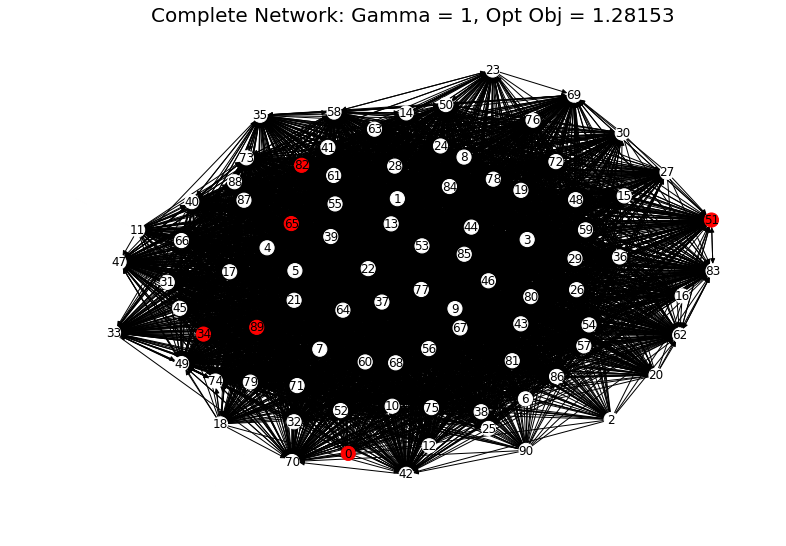

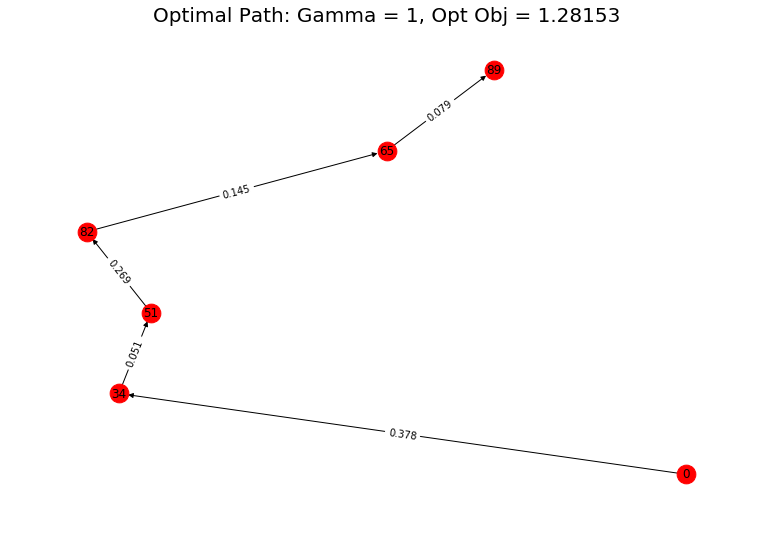


For Gamma: 2.0
Path:
[(0, 34), (34, 43), (43, 61), (61, 37), (37, 65), (65, 89)]
Cost of Movement (Objective):
1.5697475188262433


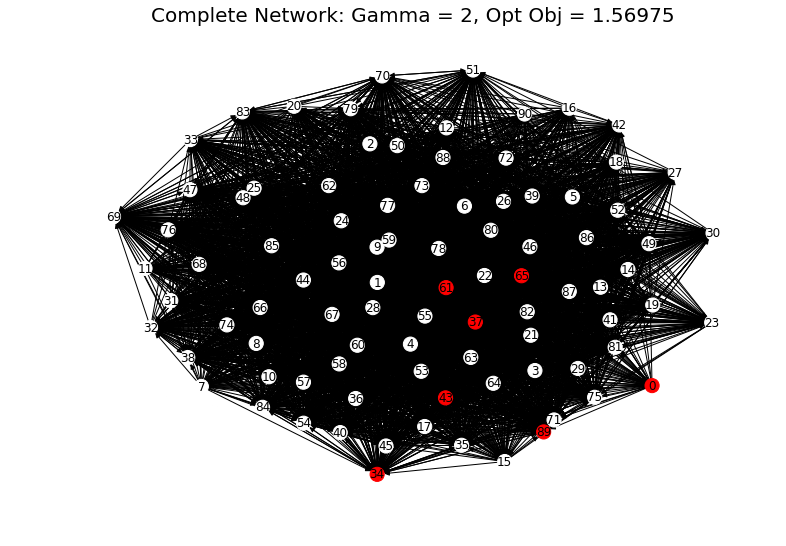

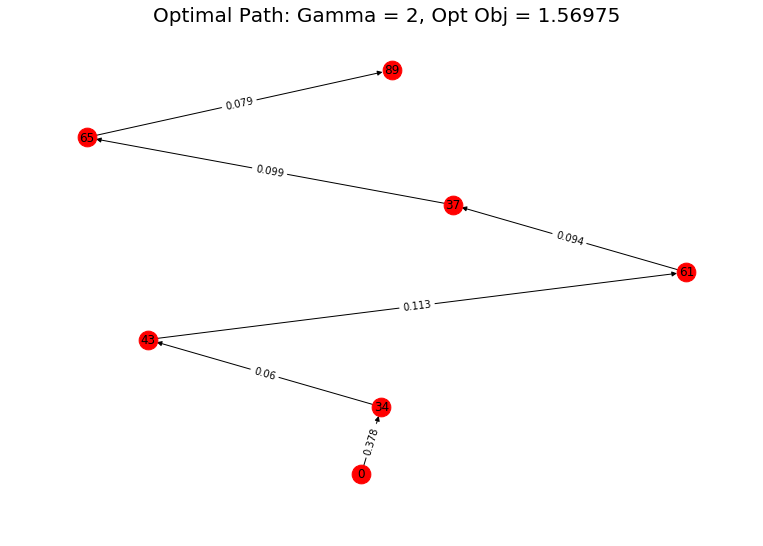


For Gamma: 3.0
Path:
[(0, 34), (34, 43), (43, 61), (61, 37), (37, 65), (65, 89)]
Cost of Movement (Objective):
1.8005042317534627


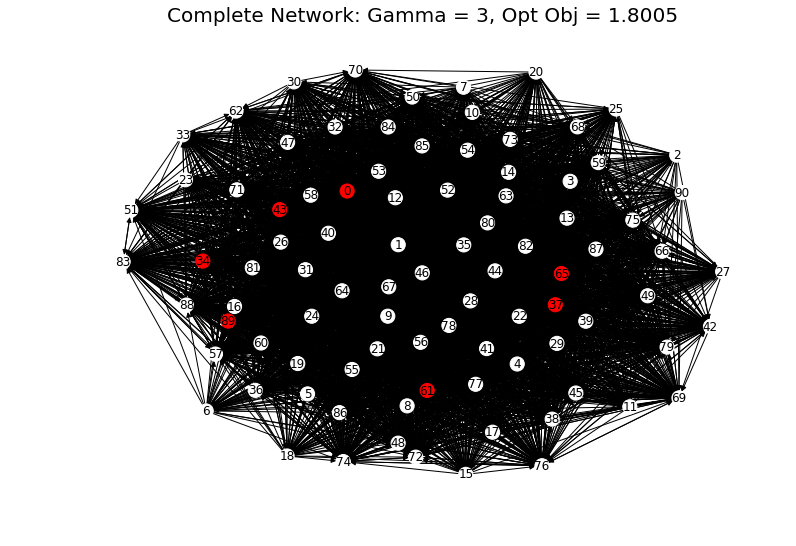

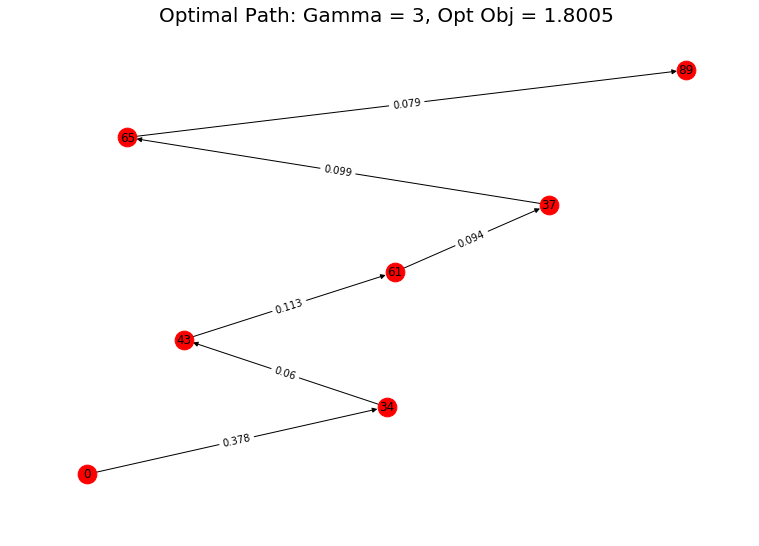


For Gamma: 4.0
Path:
[(0, 52), (52, 84), (84, 89)]
Cost of Movement (Objective):
1.9330727297958064


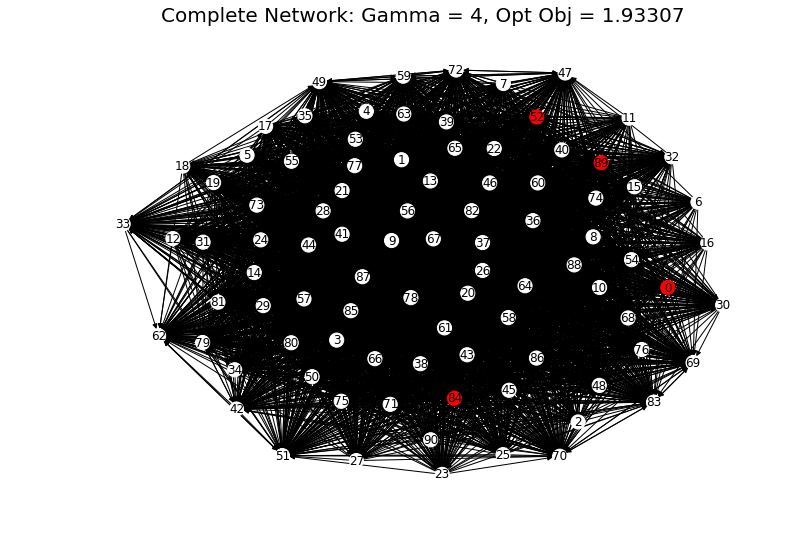

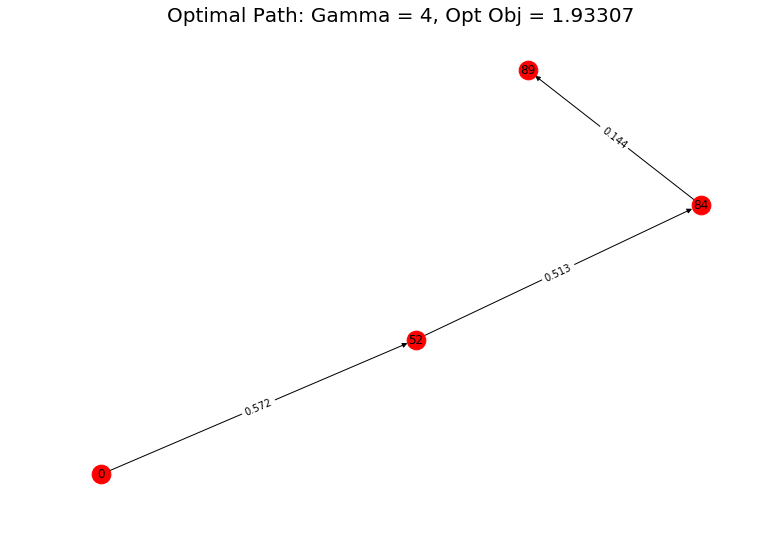

In [11]:
# print optimal values and paths, plot network
for o in output:
    print('\nFor Gamma: '+str(o[0]))
    print('Path:')
    print(o[1])
    print('Cost of Movement (Objective):')
    print(o[2])
    networkCompletePlot(o,maxNodes)
    networkPathPlot(o,maxNodes,c)